# Quantization - introduction

In [4]:
import torch
import matplotlib.pyplot as plt
# default size of figures
plt.rcParams['figure.figsize'] = [10, 10]

*Quantization* is a process of mapping input values from a large set to output values in a smaller set (np. from real values to discrete space).

Quantization improves performance and power efficiency by reducing memory access costs and increasing computing efficiency. Lower-bit quantization requires less data movement, which reduces memory bandwidth and energy consumption.

Let's start our journey with some data representations!

First, we have **unsigned INT** representation, where we simply denote numbers with following bits (from leftmost most significant bit (MSB) to least significant bit (LSB)).

$1011b = 1*2^3 + 0*2^2 + 1*2^1 + 1*2^0 = 8 + 0 + 2 + 1 = 11$

Then, we have signed **INT** representation, where we use MSB for a sign. We most often use so called `Complement Representation` where the first bit is a negative value with maximal magnitude.

$1011b = 1 * -(2^3) + 0*2^2 + 1*2^1 + 1*2^0 = -8 + 2 + 1 = -5$

$0011b = 0 * -(2^3) + 0*2^2 + 1*2^1 + 1*2^0 = 2 + 1 = 3$

We can use this approach to represent fractions as well. We use **fixed point** representation, where first digit represents a sign (in the same matter as in INT), next couple of bits represent integer part, and remaining bits represent fraction.

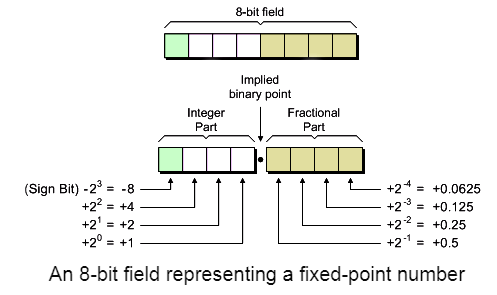

Finally, we have **floating point** representation. We'll use an IEEE-754 32-bit standard, where FP is denoted with:
- sign `S` (most significant bit - leftmost one)
- exponent `E` (following 8 bits)
- fraction `F` (remaining 23 bits)

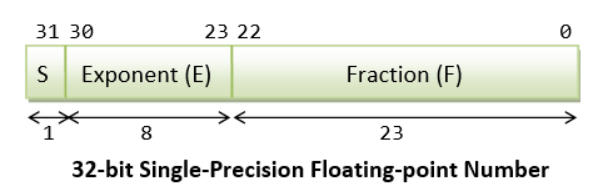

The sign tells us whether the number is positive (0) or negative (1).
The fraction can be used to represent all the digits after the "dot" (so... the fraction!). It is normalized with leading 1, so it's `1.F`.
And finally, we use the exponent to "shift" the decimal point. We use 8 bits for this part of the number, so we can get maximum value of 255. In order to get both very big and very small numbers, we actually normalize as `E-127`.

The final number we get can be described as:

$x_{FP} = (-1)^S * 1.F * 2^{E-127}$

Floating point representation has a precision good enough to assume it as a real value.

For the **first task**, let's try out some representations!

For this task, do not use built-in Python functions that convert numbers - try to implement the converstion manually.

1) Write a Python function that takes a string of eight ones and zeros as input and outputs **UINT** value represented by this string. Test it by calculating the number, that can be represented as the `00010110`

In [3]:
def bin_to_uint(bin: str) -> int:
    return sum([int(n) * (2**i) for i, n in enumerate(bin[::-1])])

In [4]:
print(bin_to_uint("00010110"))

22


2) Write a Python function that takes a string of eight ones and zeros as input and outputs **INT** value represented by this string. Test it by calculating the number, that can be represented as the `10001010`

In [5]:
def bin_to_int(bin: str) -> int:
    return sum(
        [
            int(n) * (2**i) if i != len(bin) - 1 else int(n) * -(2**i)
            for i, n in enumerate(bin[::-1])
        ]
    )

In [6]:
print(bin_to_int('10001010'))

-118


3) Write a Python function that takes a string of eight ones and zeros as input and outputs **fixed point** value represented by this string (4 bits of integer part [including sign bit], 4 bits of fraction part). Test it by calculating the number, that can be represented as the `1011 0100`

In [1]:
def bin_to_fixed(bin: str) -> float:
    int_part = bin[0:4]
    fraction_part = bin[4:]
    int_part_sum = sum(
        [
            int(n) * (2**i) if i != len(int_part) - 1 else int(n) * -(2**i)
            for i, n in enumerate(int_part[::-1])
        ]
    )
    fraction_part_sum = sum(
        [
            int(n) * (2**-(i+1))
            for i, n in enumerate(fraction_part)
        ]
    )
    return int_part_sum + fraction_part_sum
    # return float(f"{int_part_sum}.{str(fraction_part_sum).split('.')[1]}")

In [2]:
bin_to_fixed("10110100")

-4.75

4) Write a Python function that takes a string of 32 ones and zeros as input and outputs **floating point** value represented by this string. Calculate the number, that can be represented as the **floating point**: `11000000101100000000100010000100`

In [9]:
def bin_to_float(bin: str) -> int:
    S = bin[0]
    E = bin[1:9]
    F = bin[9:]

    E_decimal = bin_to_uint(E)
    E_decimal = E_decimal - 127

    F_decimal = sum(
        [int(n) * (2 ** -(i + 1)) for i, n in enumerate(F)]
    )
    F_decimal += 1
    return (-1) ** int(S) * F_decimal * 2 ** E_decimal

In [10]:
print(bin_to_float("11000000101100000000100010000100"))

-5.501039505004883


We have the basics ready, so let's quantize!

We'll start with something easy!
Create a tensor `R1` with values from linear space of range 0 to 15 and length of 1000 elements.

Print this tensor and plot it on both axes: X and Y. Add title and legend.

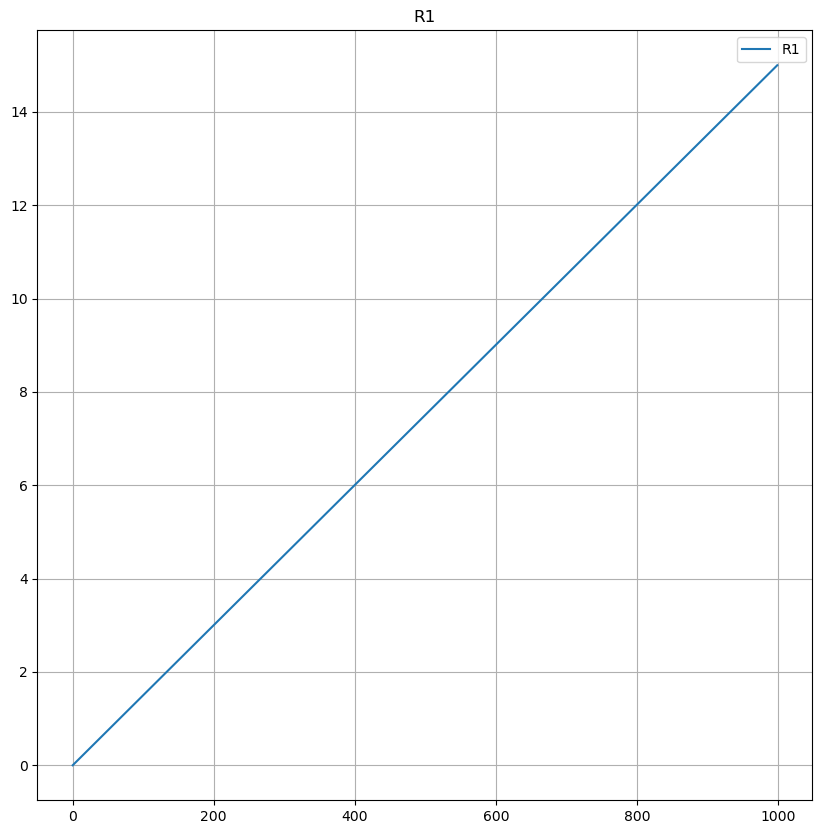

In [11]:
R1 = torch.linspace(0, 15, 1000)
plt.plot(R1, label='R1')
plt.title('R1')
plt.legend()
plt.grid()
plt.show()

Remember, that we use quantisation in case of embedded AI to reduce the precision of weights activations. Our goal is to represent the same numbers with smaller number of bits!


Let's represent those floating point numbers with integers, that can be represented with 4 bits with unsigned INT type!

That's easy! Let's just round the numbers with `torch.floor()` function! That's it!

Print `R1` tensor and quantized tensor `Q` on the same plot!

Don't change the `Q` tensor type. It's type will be still fp32, but it doesn't matter (for now) - we can use it to store quantized values, which could be stored with only 4 bits! And that is our goal, right?

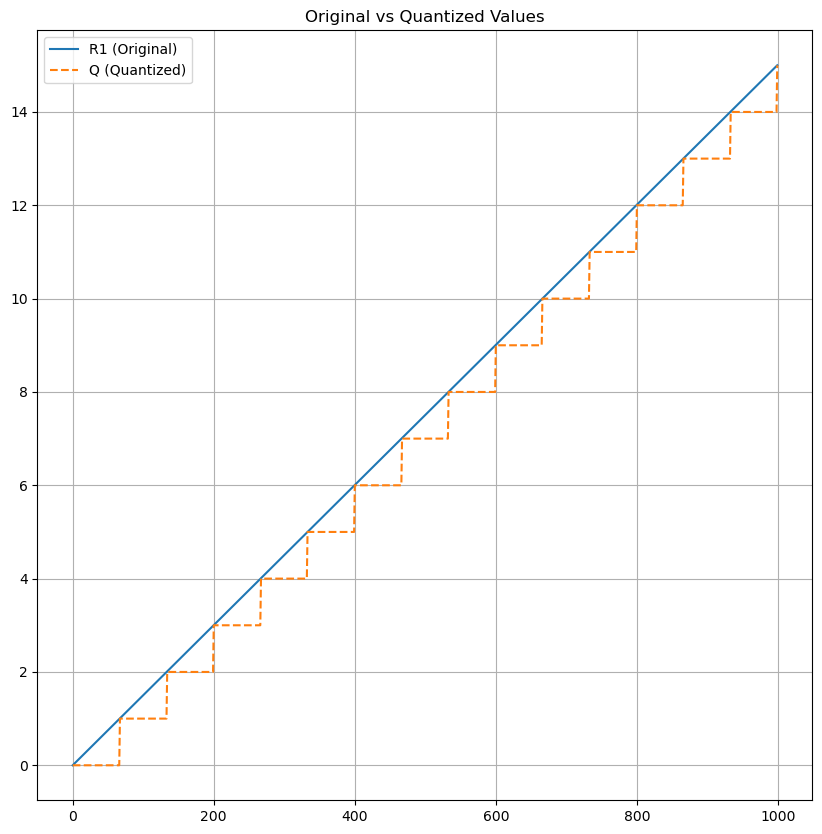

In [12]:
Q = torch.floor(R1)
plt.plot(R1, label="R1 (Original)")
plt.plot(Q, label="Q (Quantized)", linestyle="--")
plt.title("Original vs Quantized Values")
plt.legend()
plt.grid()
plt.show()

All right. But what if we have different ranges for our data?

Create a tensor `R2` with values from linear space of range -2 to 18 and length of 1000 elements.

With 4 bit INT we can not get any number smaller than 0 or bigger than $2^4-1$

Use `torch.clamp()` to limit the values.

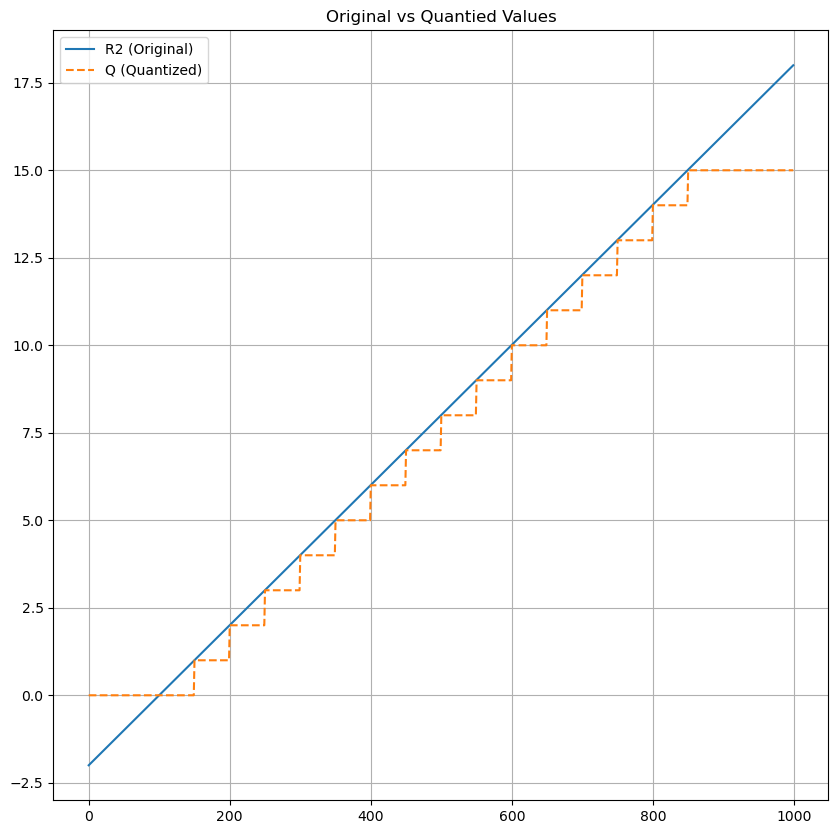

In [13]:
R2 = torch.linspace(-2, 18, 1000)
Q = torch.floor(R2)
Q = torch.clamp(Q, 0, 2 ** 4 - 1)
plt.plot(R2, label='R2 (Original)')
plt.plot(Q, label='Q (Quantized)', linestyle='--')
plt.title('Original vs Quantied Values')
plt.legend()
plt.grid()
plt.show()

Ok... But let's say, that we want to represent the fractions as well!
Let's use fixed point representation, that:
- doesn't use sign bit
- has a total of 5 bits
- uses one bit as a fraction part

Let's study this representation!
Calculate:
- What is the biggest and smallest number that you can represent with this representation?
- What's the `PRECISION` of this representation (distance between next fixed point numbers)?
- How many numbers can we represent on this discrete space (what is the discrete space size)?

Now, in order to quantize our `R1` tensor we need to `scale` it!

The `scale` is the `PRECISION` of this representation.

Divide the `R2` with calculated `scale` before using the `floor` function.

Then - multiply the result of `floor` function with the same `scale` before applying `clamp`

PRECISION: 0.5
MIN_VALUE: 0
MAX_VALUE: 15.5
DISCRETE_SPACE_SIZE: 32


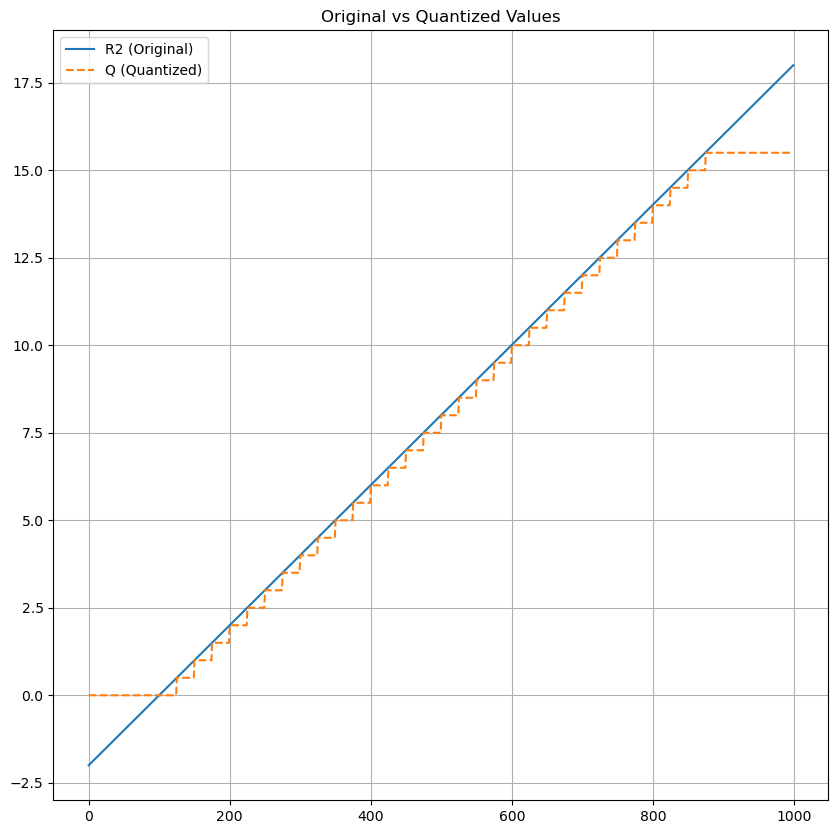

In [57]:
SIGN_BITS = 0
WIDTH_BITS = 5
FRACTION_BITS = 1
INT_BITS = WIDTH_BITS - FRACTION_BITS - SIGN_BITS

PRECISION = 2 ** -FRACTION_BITS # najmniejsza zmiana wynika z bitu ułamkowego, który reprezentuje 0.5
MIN_VALUE = 0
MAX_VALUE = (2 ** INT_BITS - 1) + PRECISION # 15 - 0.5 = 15.5
DISCRETE_SPACE_SIZE = 2 ** WIDTH_BITS

print(f"PRECISION: {PRECISION}")
print(f"MIN_VALUE: {MIN_VALUE}")
print(f"MAX_VALUE: {MAX_VALUE}")
print(f"DISCRETE_SPACE_SIZE: {DISCRETE_SPACE_SIZE}")

scale = PRECISION
Q = torch.floor(R2 / scale) * scale
Q = torch.clamp(Q, MIN_VALUE, MAX_VALUE)
plt.plot(R2, label="R2 (Original)")
plt.plot(Q, label="Q (Quantized)", linestyle="--")
plt.title("Original vs Quantized Values")
plt.legend()
plt.grid()
plt.show()

For AI, most weights and activations are numbers close to 0 (both positive and negative). We would like to be able to represent negative numbers! So let's try something harder!

Create a tensor `R3` with values from linear space of range -2.5 to 2.5 and length of 1000 elements.

As our discrete space, we'll now use fixed point representation with:
- total width of 4 bits
- 1 sign bit
- point position after second bit

Note: the sign bit is one of integer bits!

Let's study this representation!
Calculate:
- The number of bits used to represent the integer part and the fraction.
- what is the biggest and smallest number that you can represent with this representation?
- What's the precision of this representation (distance between next fixed point numbers)?
- How many numbers can we represent on this discrete space (what is the discrete space size)?

In [7]:
R3 = torch.linspace(-2.5, 2.5, 1000)

SIGN_BITS = 1
WIDTH_BITS = 4
FRACTION_BITS = 2
INT_BITS = WIDTH_BITS - FRACTION_BITS

PRECISION = 2 ** -FRACTION_BITS
MIN_INT = -(2 ** (INT_BITS - 1))
MAX_INT = 2 ** (INT_BITS - 1)
MIN_VALUE = MIN_INT
MAX_VALUE = MAX_INT - PRECISION
DISCRETE_SPACE_SIZE = 2 ** WIDTH_BITS # od -2.0 do 1.75 z krokiem 0.25

print(f"INT_BITS: {INT_BITS}")
print(f"PRECISION: {PRECISION}")
print(f"MIN_VALUE: {MIN_VALUE}")
print(f"MAX_VALUE: {MAX_VALUE}")
print(f"DISCRETE_SPACE_SIZE: {DISCRETE_SPACE_SIZE}")

INT_BITS: 2
PRECISION: 0.25
MIN_VALUE: -2
MAX_VALUE: 1.75
DISCRETE_SPACE_SIZE: 16


Try to perform quantization in the same way as previously!

Calculate the scale, use `floor` and `clamp`!

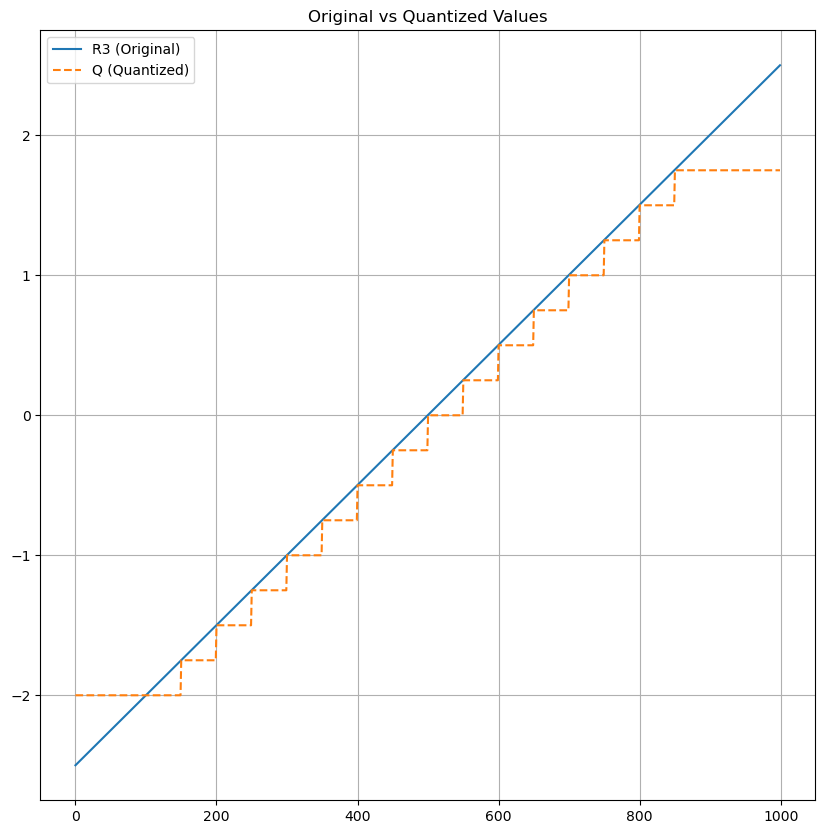

In [8]:
scale = PRECISION
Q = torch.floor(R3 / scale) * scale
Q = torch.clamp(Q, MIN_VALUE, MAX_VALUE)
plt.plot(R3, label="R3 (Original)")
plt.plot(Q, label="Q (Quantized)", linestyle="--")
plt.title("Original vs Quantized Values")
plt.legend()
plt.grid()
plt.show()

Based on the described algorithm, define a function `fixed_point_quantize`.

Function should take arguments:
- `R` - floating point tensor, which will be quantized
- `bit_width` - fixed point bit width
- `fraction_bits` - number of fraction bits / point position
- `round_method` - method of rounding, one of 'round', 'floor', 'ceil'.

Function should return quantized tensor.

In [9]:
def signed_fixed_point_quantize(R: torch.Tensor,
                                bit_width: int,
                                fraction_bits: int,
                                round_method:str = 'round') -> torch.Tensor:
    """
    Kwantyzuje tensor zmiennoprzecinkowy do stałoprzecinkowej reprezentacji liczbowej z liczbami ujemnymi.

    Args:
        R (torch.Tensor): Tensor zmiennoprzecinkowy do kwantyzacji.
        bit_width (int): Całkowita liczba bitów (szerokość bitowa).
        fraction_bits (int): Liczba bitów części ułamkowej.
        round_method (str): Metoda zaokrąglania ('round', 'floor', 'ceil').

    Returns:
        torch.Tensor: Tensor po kwantyzacji.
    """
    INT_BITS = bit_width - fraction_bits
    scale = 2 ** -fraction_bits
    PRECISION = 2 ** -fraction_bits
    MIN_INT = -2 ** (INT_BITS - 1)
    MAX_INT = 2 ** (INT_BITS - 1)
    MIN_VALUE = MIN_INT
    MAX_VALUE = MAX_INT - PRECISION

    if round_method == 'round':
        R_rounded = torch.round(R / scale) * scale
    elif round_method == 'floor':
        R_rounded = torch.floor(R / scale) * scale
    elif round_method == 'ceil':
        R_rounded = torch.ceil(R / scale) * scale
    else:
        raise ValueError("Invalid round_method. Choose 'round', 'floor', or 'ceil'.")

    quantized = torch.clamp(R_rounded, MIN_VALUE, MAX_VALUE)

    return quantized

Test function on previously created `R3` tensor.

Display both `R3` tensor and `quantized` tensor on the same plot.

Try out different rounding methods, print all tensors on the same plot.

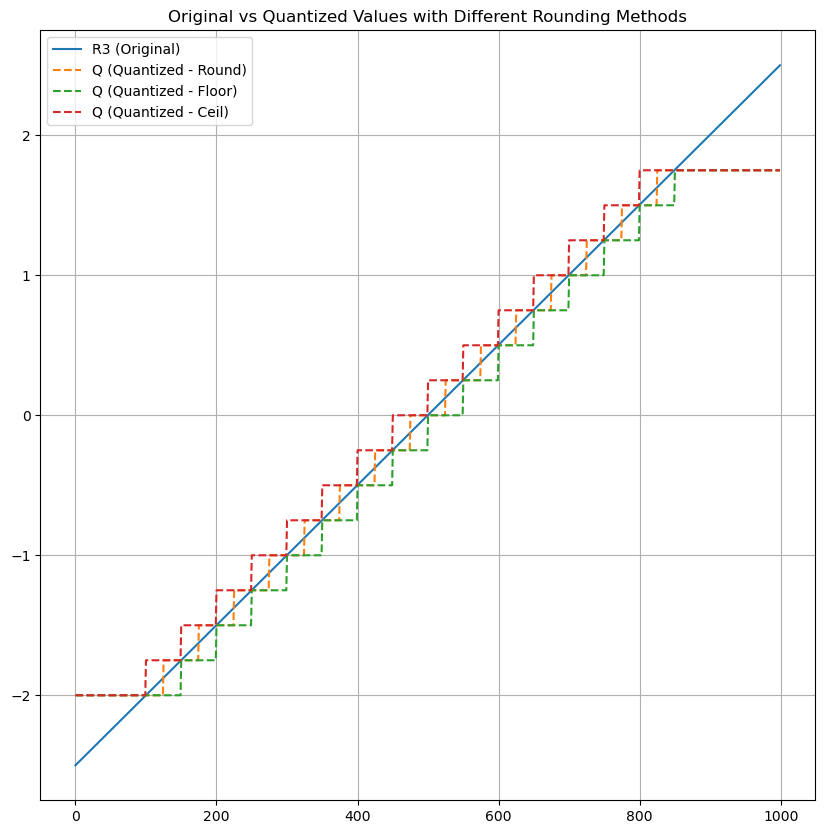

In [10]:
quantized_round = signed_fixed_point_quantize(
    R3, bit_width=4, fraction_bits=2, round_method="round"
)
quantized_floor = signed_fixed_point_quantize(
    R3, bit_width=4, fraction_bits=2, round_method="floor"
)
quantized_ceil = signed_fixed_point_quantize(
    R3, bit_width=4, fraction_bits=2, round_method="ceil"
)

# Rysowanie wykresów
plt.plot(R3, label="R3 (Original)")
plt.plot(
    quantized_round, label="Q (Quantized - Round)", linestyle="--"
)
plt.plot(
    quantized_floor, label="Q (Quantized - Floor)", linestyle="--"
)
plt.plot(quantized_ceil, label="Q (Quantized - Ceil)", linestyle="--")
plt.title("Original vs Quantized Values with Different Rounding Methods")
plt.legend()
plt.grid()
plt.show()

Before we finish, let's consider the case, where we want to represent real values with totally different set of numbers.

Create a tensor `R4` with 500 values from linear space of range -2.5 to 0 and 500 values from linear space of range 0 to 10 (you'll need `tensor.cat` function).

Let's represent this tensor with integers in range of 0-15. To do that, use following functions:

$Q(R) = floor(R/S + Z)$

where:
- `S` is simply ratio of the input range to the output range
- `Z` is `zero-point` to ensure that the smallest value in input space maps perfectly to smallest value in quantized space


$S = R_{max}-R_{min} / Q_{max}-Q_{min}$

$Z = -(R_{min}/S - Q_{min})$


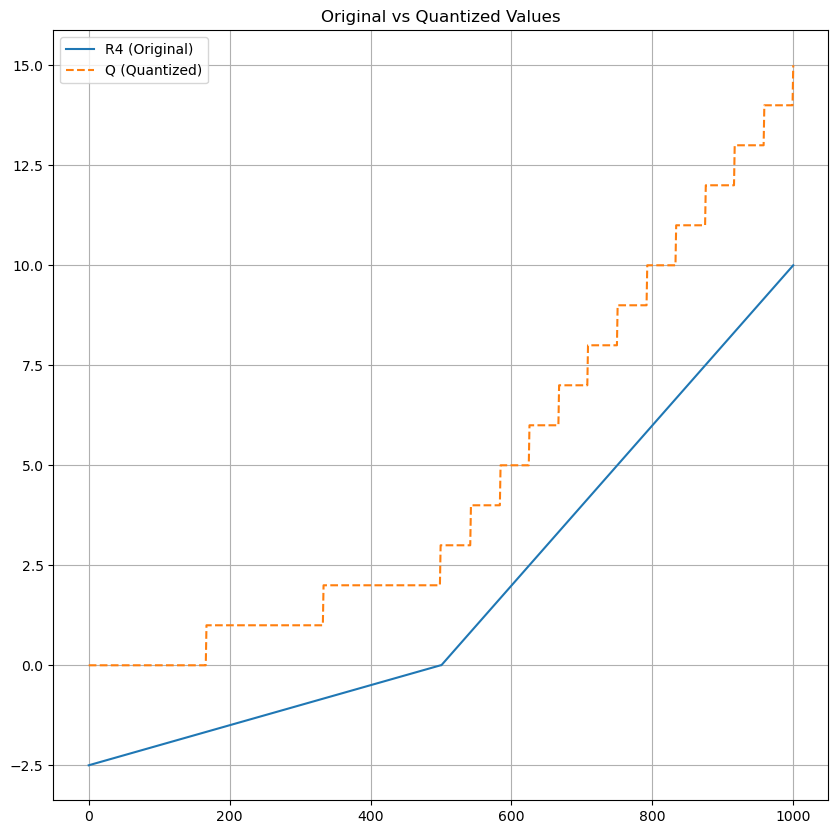

In [11]:
R_temp1 = torch.linspace(-2.5, 0, 500)
R_temp2 = torch.linspace(0, 10, 500)
R4 = torch.cat((R_temp1, R_temp2))
R_ref = torch.linspace(0, 1000, 1000)
R_min = -2.5
R_max = 10
Q_min = 0
Q_max = 15
S = (R_max - R_min) / (Q_max - Q_min)
Z = -(R_min / (S - Q_min))

Q = torch.floor(R4/S + Z)
Q = torch.clamp(Q, Q_min, Q_max)

plt.plot(R_ref, R4, label='R4 (Original)')
plt.plot(R_ref, Q, label='Q (Quantized)', linestyle='--')
plt.title("Original vs Quantized Values")
plt.legend()
plt.grid()
plt.show()

**EXTENSION EXERCISE**

Apply quantization on image `mandrill.jpg`.

Use `imread` function from OpenCV library to read image with arguments: path_to_file and value 0 (as the second arg).

Function returns numpy ndarray. Convert it to torch.Tensor and divide by 255 (normalization).

Display image with `plt.imshow`.

Apply signed quantization of 4 bits, 3 bits of precision and 'floor' rounding.

Plot resultant image.


In [12]:
import cv2

image_path = './mandrill.png'

image_np = cv2.imread(image_path, 0)

if image_np is None:
    print(
        f"Couldn't load the image. Make sure the file '{image_path}' exists"
    )
else:
    print("Image loaded successfully")

Image loaded successfully


In [13]:
image_tensor = torch.from_numpy(image_np)
image_tensor = image_tensor.type(torch.float32) / 255.0
print(f"Image shape: {image_tensor.shape}")
print(f"Image data type: {image_tensor.dtype}")
print(image_tensor)

quantized_image = signed_fixed_point_quantize(image_tensor, 4, 2, "floor")
print(f"Quantized image shape: {quantized_image.shape}")
print(f"Quantized image data type: {quantized_image.dtype}")
print(quantized_image)

Image shape: torch.Size([512, 512])
Image data type: torch.float32
tensor([[0.5686, 0.2157, 0.1882,  ..., 0.4392, 0.6000, 0.6941],
        [0.4549, 0.3961, 0.1529,  ..., 0.5059, 0.5804, 0.4902],
        [0.2980, 0.4431, 0.1804,  ..., 0.3922, 0.3451, 0.3176],
        ...,
        [0.5490, 0.5686, 0.5490,  ..., 0.3216, 0.3490, 0.3059],
        [0.6118, 0.5490, 0.5137,  ..., 0.3059, 0.3098, 0.2667],
        [0.0392, 0.0431, 0.0510,  ..., 0.0235, 0.0118, 0.0157]])
Quantized image shape: torch.Size([512, 512])
Quantized image data type: torch.float32
tensor([[0.5000, 0.0000, 0.0000,  ..., 0.2500, 0.5000, 0.5000],
        [0.2500, 0.2500, 0.0000,  ..., 0.5000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.0000,  ..., 0.2500, 0.2500, 0.2500],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.2500, 0.2500, 0.2500],
        [0.5000, 0.5000, 0.5000,  ..., 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [14]:
quantized_image_round_2 = signed_fixed_point_quantize(image_tensor, 4, 2, "round")
quantized_image_ceil_2 = signed_fixed_point_quantize(image_tensor, 4, 2, "ceil")
quantized_image_floor_2 = signed_fixed_point_quantize(image_tensor, 4, 2, "floor")

print(f"Original\n{image_tensor}")
print(f"Round\n{quantized_image_round_2}")
print(f"Ceil\n{quantized_image_ceil_2}")
print(f"Floor\n{quantized_image_floor_2}")

Original
tensor([[0.5686, 0.2157, 0.1882,  ..., 0.4392, 0.6000, 0.6941],
        [0.4549, 0.3961, 0.1529,  ..., 0.5059, 0.5804, 0.4902],
        [0.2980, 0.4431, 0.1804,  ..., 0.3922, 0.3451, 0.3176],
        ...,
        [0.5490, 0.5686, 0.5490,  ..., 0.3216, 0.3490, 0.3059],
        [0.6118, 0.5490, 0.5137,  ..., 0.3059, 0.3098, 0.2667],
        [0.0392, 0.0431, 0.0510,  ..., 0.0235, 0.0118, 0.0157]])
Round
tensor([[0.5000, 0.2500, 0.2500,  ..., 0.5000, 0.5000, 0.7500],
        [0.5000, 0.5000, 0.2500,  ..., 0.5000, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.2500,  ..., 0.5000, 0.2500, 0.2500],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.2500, 0.2500, 0.2500],
        [0.5000, 0.5000, 0.5000,  ..., 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Ceil
tensor([[0.7500, 0.2500, 0.2500,  ..., 0.5000, 0.7500, 0.7500],
        [0.5000, 0.5000, 0.2500,  ..., 0.7500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.2500,  ..., 0.5000, 0.5000, 0

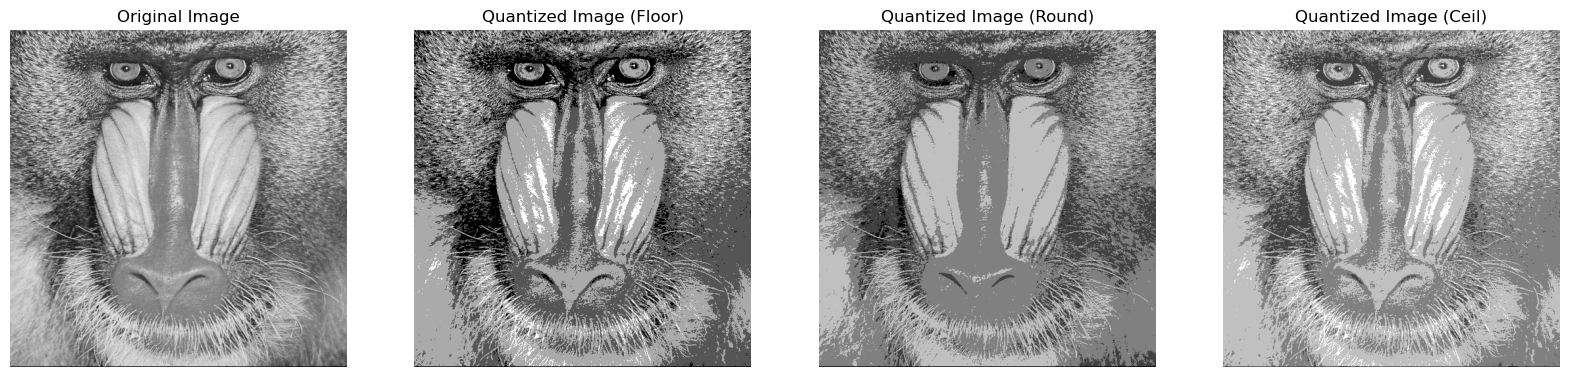

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

axes[0].imshow(image_tensor.numpy(), cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(quantized_image_floor_2.numpy(), cmap="gray")
axes[1].set_title("Quantized Image (Floor)")
axes[1].axis("off")

axes[2].imshow(quantized_image_round_2.numpy(), cmap="gray")
axes[2].set_title("Quantized Image (Round)")
axes[2].axis("off")

axes[3].imshow(quantized_image_ceil_2.numpy(), cmap="gray")
axes[3].set_title("Quantized Image (Ceil)")
axes[3].axis("off")

plt.show()

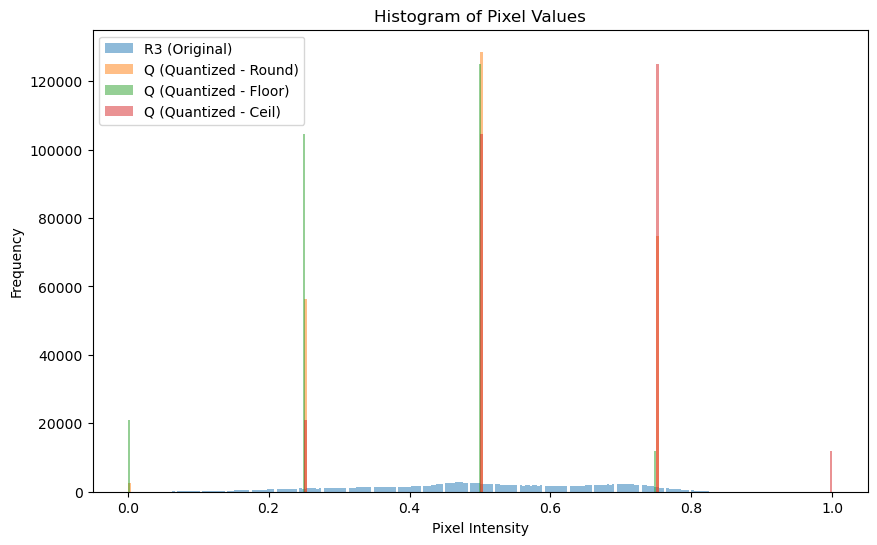

In [16]:
plt.figure(figsize=(10, 6))

plt.hist(image_tensor.flatten(), bins=256, alpha=0.5, label="R3 (Original)")
plt.hist(
    quantized_image_round_2.flatten(),
    bins=256,
    alpha=0.5,
    label="Q (Quantized - Round)",
)
plt.hist(
    quantized_image_floor_2.flatten(),
    bins=256,
    alpha=0.5,
    label="Q (Quantized - Floor)",
)
plt.hist(
    quantized_image_ceil_2.flatten(),
    bins=256,
    alpha=0.5,
    label="Q (Quantized - Ceil)",
)

plt.title("Histogram of Pixel Values")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

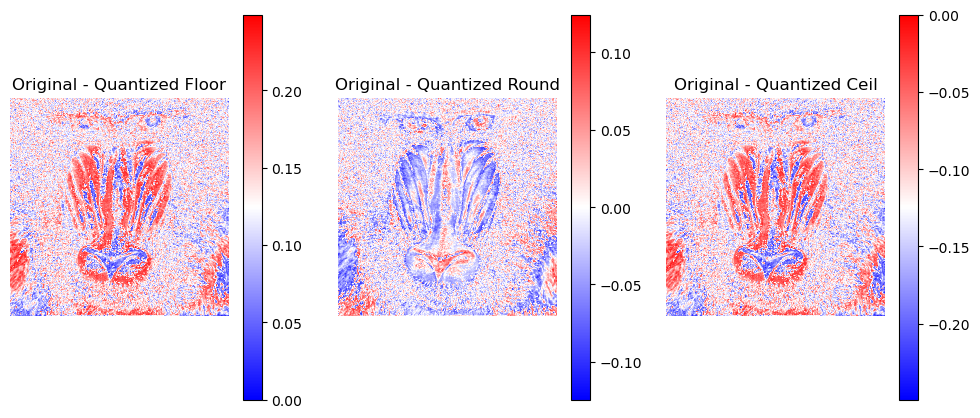

In [17]:
difference_round = image_tensor - quantized_image_round_2
difference_floor = image_tensor - quantized_image_floor_2
difference_ceil = image_tensor - quantized_image_ceil_2

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(difference_floor, cmap="bwr")
plt.title("Original - Quantized Floor")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(difference_round, cmap="bwr")
plt.title("Original - Quantized Round")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(difference_ceil, cmap="bwr")
plt.title("Original - Quantized Ceil")
plt.colorbar()
plt.axis("off")

plt.show()

In [18]:
quantized_image_round_1 = signed_fixed_point_quantize(image_tensor, 4, 1, "round")
quantized_image_ceil_1 = signed_fixed_point_quantize(image_tensor, 4, 1, "ceil")
quantized_image_floor_1 = signed_fixed_point_quantize(image_tensor, 4, 1, "floor")

print(f"Original\n{image_tensor}")
print(f"Round\n{quantized_image_round_1}")
print(f"Ceil\n{quantized_image_ceil_1}")
print(f"Floor\n{quantized_image_floor_1}")

Original
tensor([[0.5686, 0.2157, 0.1882,  ..., 0.4392, 0.6000, 0.6941],
        [0.4549, 0.3961, 0.1529,  ..., 0.5059, 0.5804, 0.4902],
        [0.2980, 0.4431, 0.1804,  ..., 0.3922, 0.3451, 0.3176],
        ...,
        [0.5490, 0.5686, 0.5490,  ..., 0.3216, 0.3490, 0.3059],
        [0.6118, 0.5490, 0.5137,  ..., 0.3059, 0.3098, 0.2667],
        [0.0392, 0.0431, 0.0510,  ..., 0.0235, 0.0118, 0.0157]])
Round
tensor([[0.5000, 0.0000, 0.0000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.0000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.0000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Ceil
tensor([[1.0000, 0.5000, 0.5000,  ..., 0.5000, 1.0000, 1.0000],
        [0.5000, 0.5000, 0.5000,  ..., 1.0000, 1.0000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0

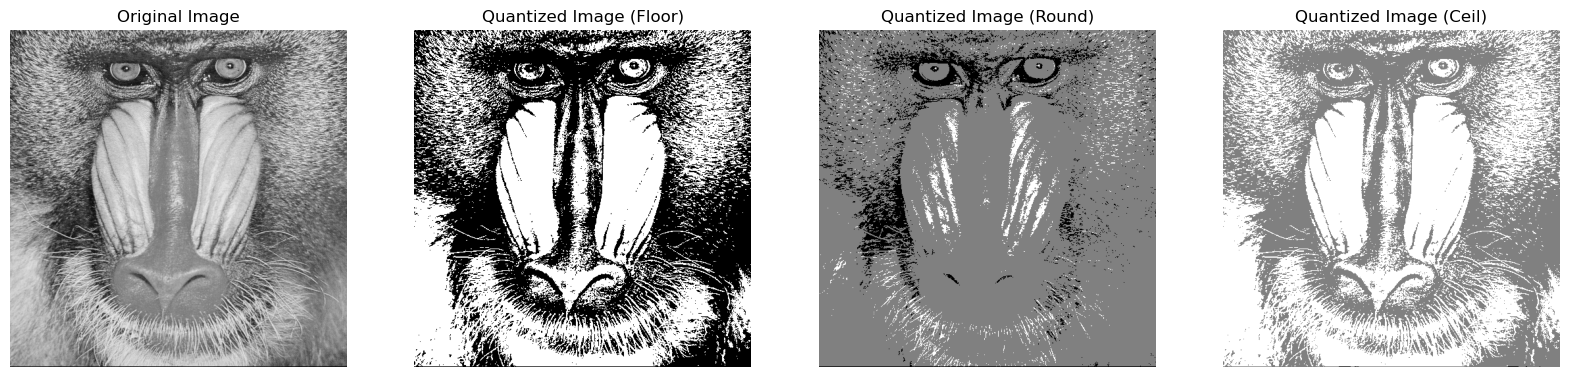

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

axes[0].imshow(image_tensor.numpy(), cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(quantized_image_floor_1.numpy(), cmap="gray")
axes[1].set_title("Quantized Image (Floor)")
axes[1].axis("off")

axes[2].imshow(quantized_image_round_1.numpy(), cmap="gray")
axes[2].set_title("Quantized Image (Round)")
axes[2].axis("off")

axes[3].imshow(quantized_image_ceil_1.numpy(), cmap="gray")
axes[3].set_title("Quantized Image (Ceil)")
axes[3].axis("off")

plt.show()

In [26]:
quantized_image_round_0 = signed_fixed_point_quantize(image_tensor, 4, 0, "round")
quantized_image_ceil_0 = signed_fixed_point_quantize(image_tensor, 4, 0, "ceil")
quantized_image_floor_0 = signed_fixed_point_quantize(image_tensor, 4, 0, "floor")

print(f"Original\n{image_tensor}")
print(f"Round\n{quantized_image_round_0}")
print(f"Ceil\n{quantized_image_ceil_0}")
print(f"Floor\n{quantized_image_floor_0}")

Original
tensor([[0.5686, 0.2157, 0.1882,  ..., 0.4392, 0.6000, 0.6941],
        [0.4549, 0.3961, 0.1529,  ..., 0.5059, 0.5804, 0.4902],
        [0.2980, 0.4431, 0.1804,  ..., 0.3922, 0.3451, 0.3176],
        ...,
        [0.5490, 0.5686, 0.5490,  ..., 0.3216, 0.3490, 0.3059],
        [0.6118, 0.5490, 0.5137,  ..., 0.3059, 0.3098, 0.2667],
        [0.0392, 0.0431, 0.0510,  ..., 0.0235, 0.0118, 0.0157]])
Round
tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Ceil
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
Floor
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0

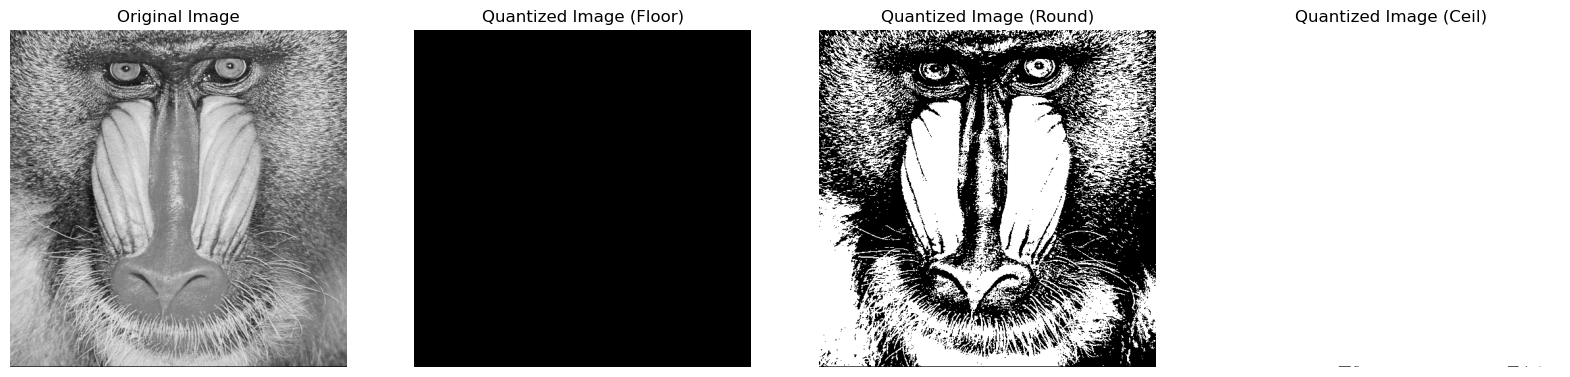

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

axes[0].imshow(image_tensor.numpy(), cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(quantized_image_floor_0.numpy(), cmap="gray")
axes[1].set_title("Quantized Image (Floor)")
axes[1].axis("off")

axes[2].imshow(quantized_image_round_0.numpy(), cmap="gray")
axes[2].set_title("Quantized Image (Round)")
axes[2].axis("off")

axes[3].imshow(quantized_image_ceil_0.numpy(), cmap="gray")
axes[3].set_title("Quantized Image (Ceil)")
axes[3].axis("off")

plt.show()

In [23]:
quantized_image_round_3 = signed_fixed_point_quantize(image_tensor, 4, 3, "round")
quantized_image_ceil_3 = signed_fixed_point_quantize(image_tensor, 4, 3, "ceil")
quantized_image_floor_3 = signed_fixed_point_quantize(image_tensor, 4, 3, "floor")

print(f"Original\n{image_tensor}")
print(f"Round\n{quantized_image_round_3}")
print(f"Ceil\n{quantized_image_ceil_3}")
print(f"Floor\n{quantized_image_floor_3}")

Original
tensor([[0.5686, 0.2157, 0.1882,  ..., 0.4392, 0.6000, 0.6941],
        [0.4549, 0.3961, 0.1529,  ..., 0.5059, 0.5804, 0.4902],
        [0.2980, 0.4431, 0.1804,  ..., 0.3922, 0.3451, 0.3176],
        ...,
        [0.5490, 0.5686, 0.5490,  ..., 0.3216, 0.3490, 0.3059],
        [0.6118, 0.5490, 0.5137,  ..., 0.3059, 0.3098, 0.2667],
        [0.0392, 0.0431, 0.0510,  ..., 0.0235, 0.0118, 0.0157]])
Round
tensor([[0.6250, 0.2500, 0.2500,  ..., 0.5000, 0.6250, 0.7500],
        [0.5000, 0.3750, 0.1250,  ..., 0.5000, 0.6250, 0.5000],
        [0.2500, 0.5000, 0.1250,  ..., 0.3750, 0.3750, 0.3750],
        ...,
        [0.5000, 0.6250, 0.5000,  ..., 0.3750, 0.3750, 0.2500],
        [0.6250, 0.5000, 0.5000,  ..., 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
Ceil
tensor([[0.6250, 0.2500, 0.2500,  ..., 0.5000, 0.6250, 0.7500],
        [0.5000, 0.5000, 0.2500,  ..., 0.6250, 0.6250, 0.5000],
        [0.3750, 0.5000, 0.2500,  ..., 0.5000, 0.3750, 0

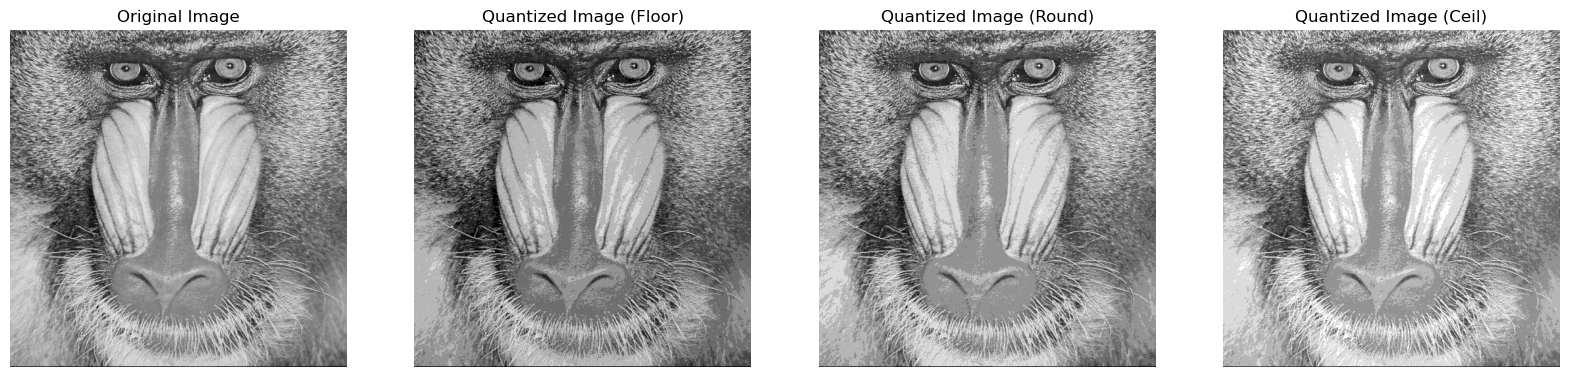

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

axes[0].imshow(image_tensor.numpy(), cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(quantized_image_floor_3.numpy(), cmap="gray")
axes[1].set_title("Quantized Image (Floor)")
axes[1].axis("off")

axes[2].imshow(quantized_image_round_3.numpy(), cmap="gray")
axes[2].set_title("Quantized Image (Round)")
axes[2].axis("off")

axes[3].imshow(quantized_image_ceil_3.numpy(), cmap="gray")
axes[3].set_title("Quantized Image (Ceil)")
axes[3].axis("off")

plt.show()